# Life Data Epidemiology - Project
### Behavioural adaption to epidemics - Fear modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math

Define activation function for fear threshold:

In [61]:
def activation_function(x,a=0.5,b=2):
     return x
     #return 1/(1+(x*(1-a)/(a*(1-x)))**(-b))

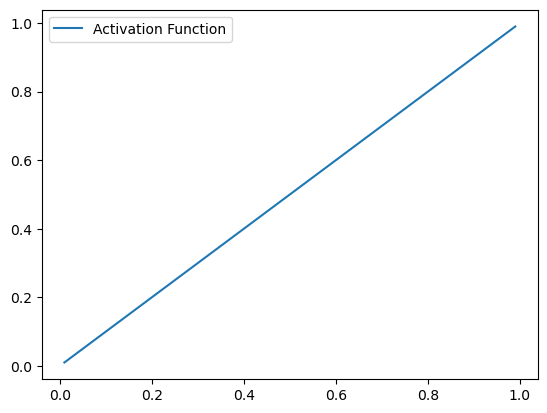

In [62]:
array = np.arange(0.01,1,0.01)
array_act_func = np.zeros(len(array))
for i in range(len(array)):
    array_act_func[i]=activation_function(array[i])
        
plt.plot(array,array_act_func,label='Activation Function')
#plt.plot(array,array, label='linear')
plt.legend()
plt.show()

Parameters:

In [63]:
beta_pred = 0.5
mu_pred = 1/6
fd_min_pred = mu_pred/10

Define **Network class**:

### CLASS

In [238]:
class Network():
    def __init__(self,N=1_000,p=0.01,m=5,initial_infecteds=10,fear_max=1., fear_max_death=2., T_max=1_000, graph_type='ERG'):
        
        if graph_type == 'ERG':
            G = nx.erdos_renyi_graph(N, p)
        if graph_type == 'BAG':
            G = nx.barabasi_albert_graph(N, m)
        ii = initial_infecteds
        index = np.arange(N)
    
        #Including status (S,I,R) attributes
        label=np.array([0]*(N-ii)+[1]*ii) 
        np.random.shuffle(label)
    
        dic_status = {index[i] : label[i] for i in range(N)}
        nx.set_node_attributes(G, dic_status,'status')
    
        #Including fear attribute
        #random fear (uniform [0,fear_max])
        fear = np.random.random(N)*fear_max
        dic_fear = {index[i] : fear[i] for i in range(N)}
        nx.set_node_attributes(G, dic_fear,'fear')

        # Get nodes degree
        all_degrees = dict(G.degree())

        degree_list = []
        for node, degree in all_degrees.items():
            degree_list.append(degree)

        degree_mean = np.mean(degree_list)
        degree_mean_2 = np.mean(np.array(degree_list)**2)
            

        self.G = G
        self.ii = initial_infecteds
        self.fear_max = fear_max
        self.fear_max_death = fear_max_death
        self.N = N
        self.p = p
        self.T_max = T_max
        self.m = m
        self.net_type = graph_type
        self.degree_mean = degree_mean
        self.degree_mean_2 = degree_mean_2

        
    def evolve_SIR_D1(self, fear_type, beta=beta_pred, mu=mu_pred, fd_min = fd_min_pred, early_stop=False, stop=400):
        
        if fear_type == 'no_fear':
            fear_max = 0
        else:
            fear_max =self.fear_max
        
        #Define network
        T_max = self.T_max
        G_initial = self.G
        N = self.N
        Edges = G_initial.number_of_edges()
        index = np.arange(N)
        
        #Initializing
        S = np.zeros(T_max)
        I = np.zeros(T_max)
        R = np.zeros(T_max)
        incidence = np.zeros(T_max)
        D = np.zeros(T_max)
        incidence_death = np.zeros(T_max)
        
        S[0] = N-self.ii
        S[1] = N-self.ii
        I[0] = self.ii
        I[1] = self.ii
        R[0] = 0
        
        t=1
    
        G = G_initial.copy()
        #Time evolution
        if early_stop == True:
            stop = stop
        elif early_stop == False:
            stop = T_max
            
        while I[t] != 0 and t != stop:
            G_step = G.copy()
            incidence_d = 0
            incidence_t = np.array([])
            for i in range(N):
                
                #Check if susceptibles break edges            
                if G_step.nodes[i]['status'] == 0: #only susceptibles can break their edges depending on their fear
                    index_neighbors = np.array(list(nx.all_neighbors(G_step, i)))
                    random_fear = np.random.random(1)
                    
                    if fear_type == 'random_unif' :
                        if random_fear < G_step.nodes[i]['fear']:
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring
    
                    if fear_type == 'neighbor':
                        infected_neighbors = [x for x in list(nx.all_neighbors(G_step, i)) if G_step.nodes[x]['status']==1]
                        if random_fear < fear_max*activation_function(len(infected_neighbors)/(len(index_neighbors)+0.001)+0.001):
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring
                                    
                    if fear_type == 'global':
                        infected_total = I[t-1]
                        if random_fear < fear_max*activation_function(infected_total/N+0.001):
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring
    
                        
                #Infection ---> Recovery or Death
                if G_step.nodes[i]['status'] == 1:
                    
                    index_neighbors = np.array(list(nx.all_neighbors(G_step, i)))
                    randoms_infected = np.random.random(len(index_neighbors))
                    mask_infected = randoms_infected < beta
                    infected_neighbors = index_neighbors[mask_infected==True]
                    for j in infected_neighbors:
                        if  G_step.nodes[j]['status'] == 0:  #infect neighbors
                            G.nodes[j]['status'] = 1
                            incidence_t = np.append(incidence_t,j)
                    
                    #Recovery
                    random_mu = np.random.random(1)
                    if random_mu < mu:
                        G.nodes[i]['status'] = 2
                          
                    #Death
                    random_death = np.random.random(1)
                    if ((random_death > mu) & (random_death < fd_min + mu)):
                        G.nodes[i]['status'] = 3
                        #G.remove_node(i)
                        incidence_d = incidence_d + 1
                
            
            attributes_status = list(nx.get_node_attributes(G,'status').values())
    
            incidence[t] = len(set(incidence_t))
            incidence_death[t] = incidence_d
            
            t = t+1
            S[t] = attributes_status.count(0)
            I[t] = attributes_status.count(1)
            R[t] = attributes_status.count(2)
            D[t] = attributes_status.count(3)
    
        S = S[:t]
        I = I[:t]
        R = R[:t]
        D = D[:t]

        incidence = incidence[:t]
        incidence_death = incidence_death[:t]
        time = np.arange(t)
        cut = Edges-G.number_of_edges()

        return(S,I,R, D, incidence, incidence_death, time, cut)
        
             
       

    def evolve_SIR_D2(self,fear_type, beta=beta_pred, mu=mu_pred, fd_min = fd_min_pred, early_stop = False, stop=400):

        if fear_type == 'no_fear':
            fear_max = 0
        else:
            fear_max =self.fear_max
            fear_max_death = self.fear_max_death
        
        #Define network
        T_max = self.T_max
        G_initial = self.G
        N = self.N
        Edges = G_initial.number_of_edges()
        index = np.arange(N)
        
        #Initializing
        S = np.zeros(T_max)
        I = np.zeros(T_max)
        R = np.zeros(T_max)
        D = np.zeros(T_max)
        incidence = np.zeros(T_max)
        incidence_death = np.zeros(T_max)
                
        S[0] = N-self.ii
        S[1] = N-self.ii
        I[0] = self.ii
        I[1] = self.ii
        R[0] = 0
        D[0] = 0
        
        t=1
    
        G = G_initial.copy()
        #Time evolution
        if early_stop == True:
            stop = stop
        elif early_stop == False:
            stop = T_max
        
        while I[t] != 0 and t != stop:
            G_step = G.copy()
            incidence_t = np.array([])
            incidence_d = 0
            for i in range(N):
                
                #Check if susceptibles break edges
                if G_step.nodes[i]['status'] == 0: #only susceptibles can break their edges depending on their fear
                    index_neighbors = np.array(list(nx.all_neighbors(G, i)))
                    random_fear = np.random.random(1)

                    if fear_type == 'random_unif' :
                        if random_fear < G_step.nodes[i]['fear']:
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring
    
                    if fear_type == 'neighbor':
                        infected_neighbors = [y for y in list(nx.all_neighbors(G_step, i)) if G_step.nodes[y]['status']==1]
                        death_neighbors = [y for y in list(nx.all_neighbors(G_step, i)) if G_step.nodes[y]['status']==4]
                        if random_fear < (fear_max*activation_function(len(infected_neighbors)/(len(index_neighbors)+0.001)+0.001) + min(1,fear_max_death*activation_function(len(death_neighbors)/(len(index_neighbors)+0.001)+0.001))):
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring
                                    
                    if fear_type == 'global':
                        infected_total = I[t-1]
                        death_total = D[t-1]
                        if random_fear < (fear_max*activation_function(infected_total/N + 0.001) + min(1, fear_max_death*activation_function(death_total/N + 0.001))):
                            for k in range(len(index_neighbors)):
                                if G_step.nodes[index_neighbors[k]]['status'] == 1: #break all edges with infected nodes
                                    G.remove_edge(i,index_neighbors[k]) #no rewiring                        
                                    
                                    
                #Check if infectious break edges                    
                if G_step.nodes[i]['status'] == 1: 
                    index_neighbors = np.array(list(nx.all_neighbors(G, i)))
                    random_fear = np.random.random(1)

                    if fear_type == 'random_unif' :
                        if random_fear < G_step.nodes[i]['fear']:
                            for k in range(len(index_neighbors)):   #break edges with all neighbors
                                G.remove_edge(i,index_neighbors[k]) #no rewiring
    
                    if fear_type == 'neighbor':
                        infected_neighbors = [y for y in list(nx.all_neighbors(G_step, i)) if G_step.nodes[y]['status']==1]
                        death_neighbors = [y for y in list(nx.all_neighbors(G_step, i)) if G_step.nodes[y]['status']==4]
                        if random_fear < (fear_max*activation_function(len(infected_neighbors)/(len(index_neighbors)+0.001)+0.001) + min(1,fear_max_death*activation_function(len(death_neighbors)/(len(index_neighbors)+0.001)+0.001))):
                            for k in range(len(index_neighbors)):   #break edges with all neighbors
                                G.remove_edge(i,index_neighbors[k]) #no rewiring
                                    
                    if fear_type == 'global':
                        infected_total = I[t-1]
                        death_total = D[t-1]
                        if random_fear < (fear_max*activation_function(infected_total/N + 0.001) + min(1, fear_max_death*activation_function(death_total/N + 0.001))):
                            for k in range(len(index_neighbors)):   #break edges with all neighbors
                                G.remove_edge(i,index_neighbors[k]) #no rewiring
                                
    
                        
                #Infection ---> Recovery or Death
                if G_step.nodes[i]['status'] == 1:
                    index_neighbors = np.array(list(nx.all_neighbors(G_step, i)))
                    randoms_infected = np.random.random(len(index_neighbors))
                    mask_infected = randoms_infected < beta
                    infected_neighbors = index_neighbors[mask_infected==True]
                    for j in infected_neighbors:
                        if  G_step.nodes[j]['status'] == 0:
                            G.nodes[j]['status'] = 1    #infect neighbors
                            incidence_t = np.append(incidence_t,j)
                                           
                    #Recovery
                    random_mu = np.random.random(1)
                    if random_mu < mu:
                        G.nodes[i]['status'] = 2
                          
                    #Death
                    random_death = np.random.random(1)
                    if ((random_death > mu) & (random_death < fd_min + mu)):
                        G.nodes[i]['status'] = 3
                        #G.remove_node(i)
                        incidence_d = incidence_d + 1
                        
                    
            attributes_status = list(nx.get_node_attributes(G,'status').values())
            
            incidence[t] = len(set(incidence_t))
            incidence_death[t] = incidence_d
            t = t+1
            S[t] = attributes_status.count(0)
            I[t] = attributes_status.count(1)
            R[t] = attributes_status.count(2)
            D[t] = attributes_status.count(3)
            
    
        S = S[:t]
        I = I[:t]
        R = R[:t]
        D = D[:t]
        incidence = incidence[:t]
        incidence_death = incidence_death[:t]
        time = np.arange(t)
        cut = Edges-G.number_of_edges()
        
        return(S,I,R, D, incidence, incidence_death, time, cut)

    

    def plot_SIR_D(self, model, fear_type, beta=beta_pred, mu=mu_pred, fd_min = fd_min_pred, early_stop=False, stop=400):
        T_max = self.T_max
        if model=='SIR_D1':
            S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D1(fear_type, beta, mu, fd_min, early_stop, stop)
            plt.figure(figsize = (6, 2.75))
            plt.plot(time,S/self.N,label='s')
            plt.plot(time,I/self.N,label='i')
            plt.plot(time,R/self.N,label='r')
            plt.plot(time,D/self.N,label='d')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel('Density')
            plt.title(f'SIRD 1, fear type = {fear_type}')
            print(f'cut edges {cut}')
        
        if model=='SIR_D2':
            S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D2(fear_type, beta, mu, fd_min, early_stop, stop)
            plt.figure(figsize = (6, 2.75))
            plt.plot(time,S/self.N,label='s')
            plt.plot(time,I/self.N,label='i')
            plt.plot(time,R/self.N,label='r')
            plt.plot(time,D/self.N,label='d')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel('Density')
            plt.title(f'SIRD 2, fear type = {fear_type}')
            print(f'cut edges {cut}')

    def plot_attack_rate_SIR_D(self, model, fear_type, mu=mu_pred, fd_min = fd_min_pred, num_simulations=30, num_avg=10, plot = True, early_stop=False, stop=400):
        
        G = self.G
        N = self.N
        net_type = self.net_type
        
        if net_type == 'ERG':
            mean_k = self.degree_mean
            mean_k_2 = self.degree_mean_2
            beta_list = np.linspace(0, 8*mu/mean_k, num_simulations)
            R0 = beta_list*mean_k/mu
            
        elif net_type == 'BAG':
            mean_k = self.degree_mean
            mean_k_2 = self.degree_mean_2
            beta_list = np.linspace(0, 8*mu*mean_k/(mean_k_2 - mean_k), num_simulations)
            R0 = beta_list*(mean_k_2 - mean_k)/(mean_k*mu)
            
            
        T_max = self.T_max
        Edges = self.G.number_of_edges()
        attack_rate = np.zeros(num_simulations)
        attack_rate_death = np.zeros(num_simulations)
        cut_avg = 0
 
        if model=='SIR_D1': 
            for i in range(num_simulations):
                I_mean = 0
                D_mean = 0
                for j in range(num_avg):
                    S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D1(fear_type, beta = beta_list[i], mu = mu, fd_min = fd_min, early_stop=early_stop, stop=stop)
                    I_mean = I_mean + np.sum(incidence/num_avg)
                    D_mean = D_mean + np.sum(incidence_death/num_avg)
                    cut_avg = cut_avg + cut/num_avg/num_simulations
                attack_rate[i] = I_mean
                attack_rate_death[i] = D_mean

            if plot:
                plt.plot(R0,attack_rate/self.N, label = 'Attack rate')
                plt.plot(R0,attack_rate_death/self.N, label = 'Attack rate death')
                plt.legend()
                plt.xlabel('R0')
                plt.ylabel('Total attack rate')
                plt.title(f'SIRD 1, fear type = {fear_type}')
                
        if model=='SIR_D2':
            for i in range(num_simulations):
                I_mean = 0
                D_mean = 0
                for j in range(num_avg):
                    S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D2(fear_type, beta = beta_list[i], mu = mu, fd_min = fd_min, early_stop=early_stop, stop=stop)
                    I_mean = I_mean + np.sum(incidence/num_avg)
                    D_mean = D_mean + np.sum(incidence_death/num_avg)
                    cut_avg = cut_avg + cut/num_avg/num_simulations
                attack_rate[i] = I_mean
                attack_rate_death[i] = D_mean

            if plot:
                plt.plot(R0,attack_rate/self.N, label = 'Attack rate')
                plt.plot(R0,attack_rate_death/self.N, label = 'Attack rate death')
                plt.legend()
                plt.xlabel('R0')
                plt.ylabel('Total attack rate')
                plt.title(f'SIRD 2, fear type = {fear_type}')
                
        return (R0,attack_rate/N, attack_rate_death/N, cut_avg)
    
           
    def plot_incidence_SIR_D(self, model, fear_type, beta=beta_pred, mu=mu_pred, fd_min = fd_min_pred, num_avg=20, plot=False, early_stop=False, stop=400):
        T_max = self.T_max
        incidence_avg = np.zeros(T_max)
        incidence_death_avg = np.zeros(T_max)
        cut_avg = 0
        
        if model=='SIR_D1':
            for i in range(num_avg):
                S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D1(fear_type, beta = beta, mu = mu, fd_min = fd_min, early_stop=early_stop, stop=stop)
                incidence_i = np.concatenate([incidence,np.zeros(T_max-len(incidence))])
                incidence_avg = incidence_avg + incidence_i/num_avg

                incidence_death_i = np.concatenate([incidence_death,np.zeros(T_max-len(incidence))])
                incidence_death_avg = incidence_death_avg + incidence_death_i/num_avg

                cut_avg = cut_avg + cut/num_avg

            if plot == True:
                plt.plot(np.arange(0,100,1),incidence_avg[:100],label='Infected')
                plt.plot(np.arange(0,100,1),incidence_death_avg[:100]*5,label='Dead*5')
                plt.xlabel('time')
                plt.ylabel('Incidence')
                plt.title(f'SIR_D 1, fear_type={fear_type}')
                plt.legend()
            
        if model=='SIR_D2':
            for i in range(num_avg):
                S,I,R,D,incidence,incidence_death,time,cut = self.evolve_SIR_D2(fear_type, beta = beta, mu = mu, fd_min = fd_min, early_stop=early_stop, stop=stop)
                incidence_i = np.concatenate([incidence,np.zeros(T_max-len(incidence))])
                incidence_avg = incidence_avg + incidence_i/num_avg

                incidence_death_i = np.concatenate([incidence_death,np.zeros(T_max-len(incidence))])
                incidence_death_avg = incidence_death_avg + incidence_death_i/num_avg

                cut_avg = cut_avg + cut/num_avg

                if plot == True:
                    plt.plot(np.arange(0,100,1),incidence_avg[:100],label='Infected')
                    plt.plot(np.arange(0,100,1),incidence_death_avg[:100]*5,label='Dead*5')
                    plt.xlabel('time')
                    plt.ylabel('Incidence')
                    plt.title(f'SIR_D 2, fear_type={fear_type}')
                    plt.legend()
                    
        return(incidence_avg/self.N, incidence_death_avg/self.N, cut_avg)           
            
                

Define **Networks**:

In [239]:
net_1000_ERG = Network(N=1000, graph_type = 'ERG')
net_1000_BAG = Network(N=1000, graph_type = 'BAG')

### Evolution plots

- ###### No fear

cut edges 0


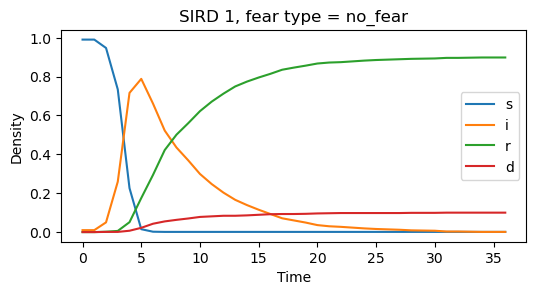

In [115]:
net_1000_ERG.plot_SIR_D('SIR_D1',fear_type='no_fear')

cut edges 0


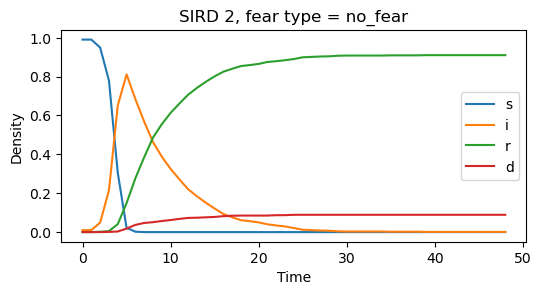

In [116]:
net_1000_ERG.plot_SIR_D('SIR_D2',fear_type='no_fear')

- ###### Random

cut edges 1755


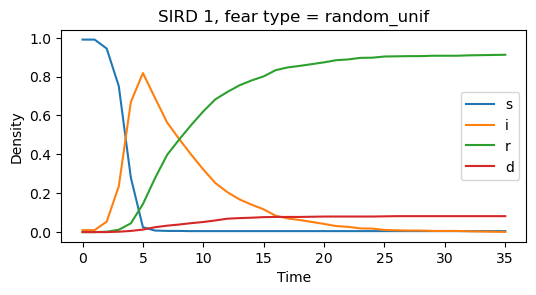

In [117]:
net_1000_ERG.plot_SIR_D('SIR_D1', fear_type='random_unif')

cut edges 4744


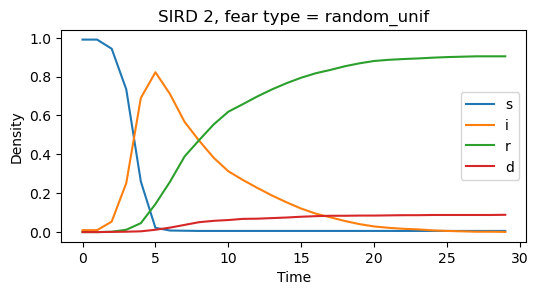

In [118]:
net_1000_ERG.plot_SIR_D(model='SIR_D2',fear_type='random_unif')

- ##### Neighbor

cut edges 1612


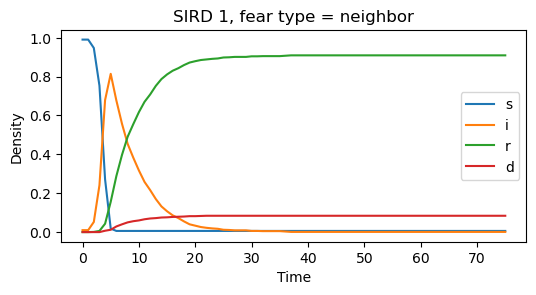

In [119]:
net_1000_ERG.plot_SIR_D('SIR_D1', fear_type='neighbor')

cut edges 4886


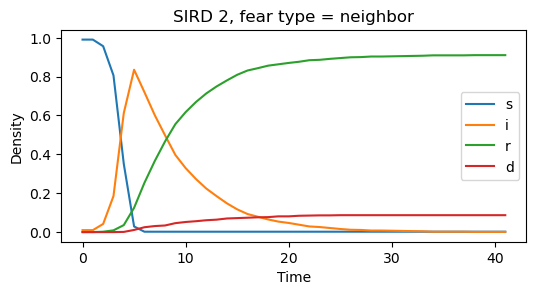

In [120]:
net_1000_ERG.plot_SIR_D('SIR_D2', fear_type='neighbor')

- ##### Global 

cut edges 422


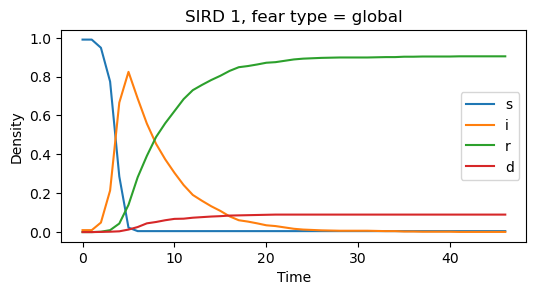

In [121]:
net_1000_ERG.plot_SIR_D('SIR_D1', fear_type='global')

cut edges 4722


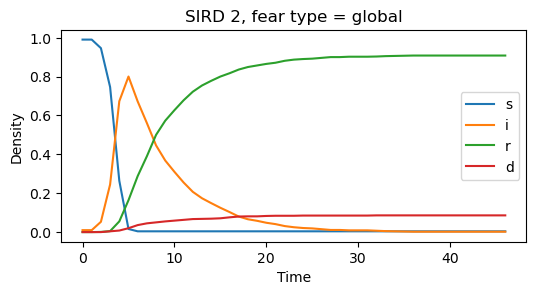

In [122]:
net_1000_ERG.plot_SIR_D('SIR_D2', fear_type='global')

# RESULTS

## 1) Compare models fixing fear type:

#### ER graph

- ##### No fear

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'no_fear', num_simulations=10, num_avg=5, plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'no_fear', num_simulations=10, num_avg=5, plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('No fear')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('No fear')
plt.show()

- ##### Random

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'random_unif', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'random_unif', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Random')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Random')
plt.show()

- ##### Neighbor

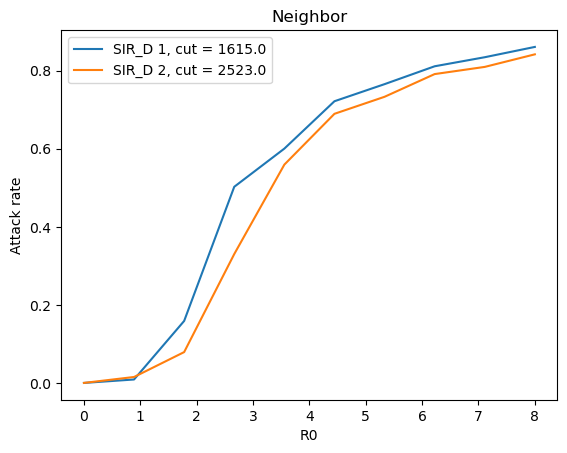

In [79]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'neighbor', num_simulations=10, num_avg=5, plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'neighbor', num_simulations=10, num_avg=5, plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Neighbor')
plt.show()

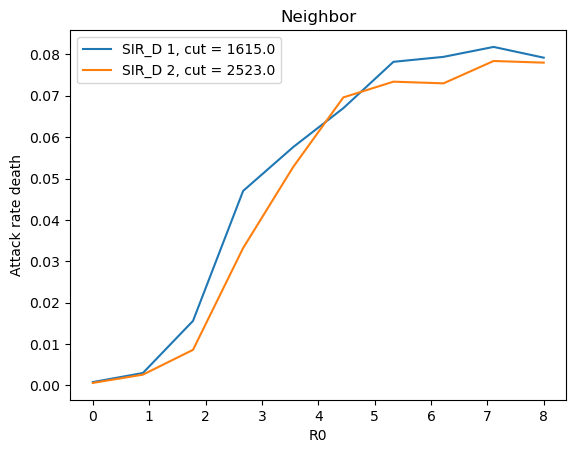

In [80]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Neighbor')
plt.show()

- ##### Global

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'global', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_ERG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'global', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Global')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Global')
plt.show()

#### BA graph

- ##### No fear

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'no_fear', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'no_fear', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('No fear')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('No fear')
plt.show()

- ##### Random

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'random_unif', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'random_unif', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Random')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Random')
plt.show()

- #### Neighbor

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'neighbor', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'neighbor', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Neighbor')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Neighbor')
plt.show()

- #### Global

In [ ]:
R0_SIRD_1, attack_rate_SIRD_1, attack_rate_death_SIRD_1, cut_SIRD_1 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D1', fear_type = 'global', plot = False)
R0_SIRD_2, attack_rate_SIRD_2, attack_rate_death_SIRD_2, cut_SIRD_2 = net_1000_BAG.plot_attack_rate_SIR_D(model = 'SIR_D2', fear_type = 'global', plot = False)

plt.plot(R0_SIRD_1, attack_rate_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate')
plt.title('Global')
plt.show()

In [ ]:
plt.plot(R0_SIRD_1, attack_rate_death_SIRD_1, label = f'SIR_D 1, cut = {np.round(cut_SIRD_1)}')
plt.plot(R0_SIRD_2, attack_rate_death_SIRD_2, label = f'SIR_D 2, cut = {np.round(cut_SIRD_2)}')
plt.legend()
plt.xlabel('R0')
plt.ylabel('Attack rate death')
plt.title('Global')
plt.show()

## 2) Attack-rate vs R0 comparison for all fear kinds in one same model

In [48]:
def attack_rate_vs_R0(model, graph):
    fear_types = ['no_fear', 'random_unif', 'neighbor', 'global']
    attack_rate_list = []
    attack_rate_death_list = []
    cut_avg_list = []
    
    if graph == 'ERG':
        network = net_1000_ERG
    if graph == 'BAG':
        network = net_1000_BAG
    
    for i in range(len(fear_types)):
        R0, attack_rate, attack_rate_death, cut_avg = network.plot_attack_rate_SIR_D(model = model, fear_type = fear_types[i], num_simulations=80, num_avg=40, plot=False)
        attack_rate_list.append(attack_rate)
        attack_rate_death_list.append(attack_rate_death)
        cut_avg_list.append(cut_avg)
    return(R0, attack_rate_list, attack_rate_death_list, cut_avg_list)

def plot_attack_rate_vs_R0(model, infected_or_dead, R0, attack_rate_list, attack_rate_death_list, cut_avg_list):
    
    fear_types = ['No fear', 'Random', 'Neighbor', 'Global']
    plt.figure(figsize = (6, 2.75))
    
    if infected_or_dead=='infected':
        for i in range(len(fear_types)):
            plt.plot(R0, attack_rate_list[i], label = f'{fear_types[i]}, cut={np.round(cut_avg_list[i])}')
        plt.legend()
        plt.xlabel('R0')
        plt.ylabel('Attack rate')
        plt.title(model)
    if infected_or_dead=='dead':
        for i in range(len(fear_types)):
            plt.plot(R0, attack_rate_death_list[i], label = f'{fear_types[i]}, cut={np.round(cut_avg_list[i])}')
        plt.legend()
        plt.xlabel('R0')
        plt.ylabel('Death attack rate')
        plt.title(model)

### Graph A) ERDOS RENYI

#### A.1) All fears compared for SIRD1

In [23]:
R0_ERG_1, attack_rate_list_ERG_1, attack_rate_death_list_ERG_1, cut_avg_list_ERG_1 = attack_rate_vs_R0('SIR_D1', 'ERG')

##### Infected Attack Rate

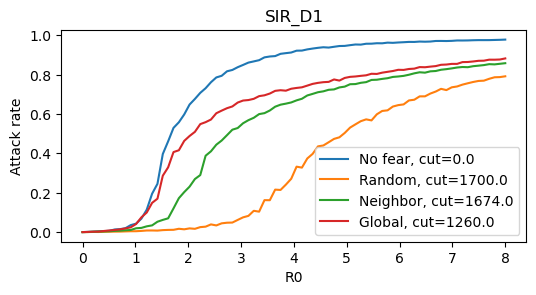

In [49]:
plot_attack_rate_vs_R0('SIR_D1', 'infected', R0_ERG_1, attack_rate_list_ERG_1, attack_rate_death_list_ERG_1, cut_avg_list_ERG_1)

##### Dead Attack Rate

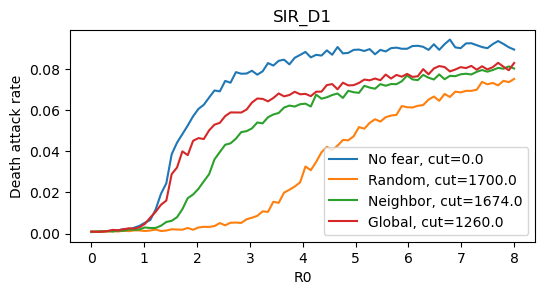

In [50]:
plot_attack_rate_vs_R0('SIR_D1', 'dead', R0_ERG_1, attack_rate_list_ERG_1, attack_rate_death_list_ERG_1, cut_avg_list_ERG_1)

#### A.2) All fears compared for SIRD2

In [26]:
R0_ERG_2, attack_rate_list_ERG_2, attack_rate_death_list_ERG_2, cut_avg_list_ERG_2 = attack_rate_vs_R0('SIR_D2', 'ERG')

##### Infected Attack Rate

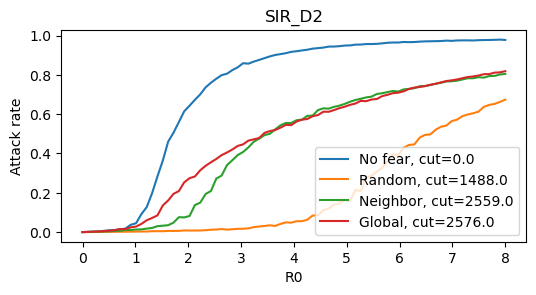

In [51]:
plot_attack_rate_vs_R0('SIR_D2', 'infected', R0_ERG_2, attack_rate_list_ERG_2, attack_rate_death_list_ERG_2, cut_avg_list_ERG_2)

##### Dead Attack Rate

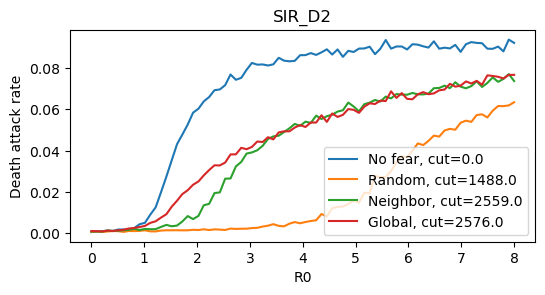

In [52]:
plot_attack_rate_vs_R0('SIR_D2', 'dead', R0_ERG_2, attack_rate_list_ERG_2, attack_rate_death_list_ERG_2, cut_avg_list_ERG_2)

### Graph B) Barabasi-Albert

#### B.1) All fears compared for SIRD1

In [29]:
R0_BAG_1, attack_rate_list_BAG_1, attack_rate_death_list_BAG_1, cut_avg_list_BAG_1 = attack_rate_vs_R0('SIR_D1', 'BAG')

##### Infected Attack Rate

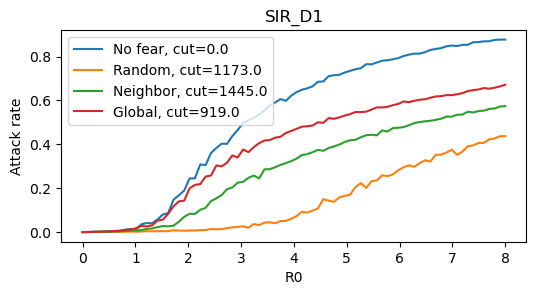

In [53]:
plot_attack_rate_vs_R0('SIR_D1', 'infected', R0_BAG_1, attack_rate_list_BAG_1, attack_rate_death_list_BAG_1, cut_avg_list_BAG_1  )

##### Dead Attack Rate

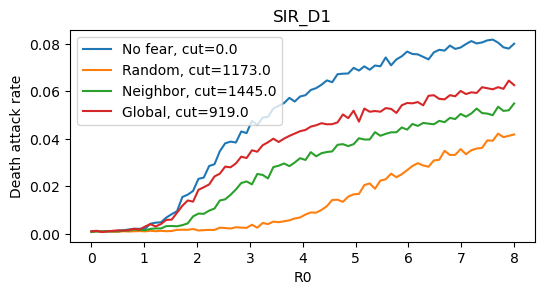

In [54]:
plot_attack_rate_vs_R0('SIR_D1', 'dead', R0_BAG_1, attack_rate_list_BAG_1, attack_rate_death_list_BAG_1, cut_avg_list_BAG_1 )

#### B.2) All fears compared for SIRD2

In [55]:
R0_BAG_2, attack_rate_list_BAG_2, attack_rate_death_list_BAG_2, cut_avg_list_BAG_2 = attack_rate_vs_R0('SIR_D2', 'BAG')

##### Infected Attack Rate

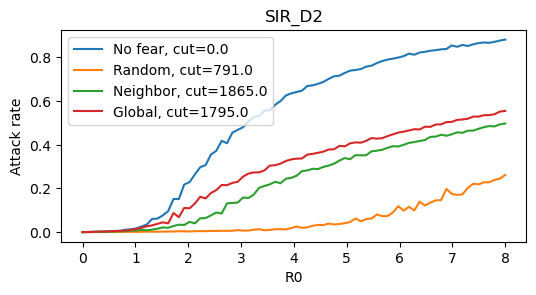

In [56]:
plot_attack_rate_vs_R0('SIR_D2', 'infected', R0_BAG_2, attack_rate_list_BAG_2, attack_rate_death_list_BAG_2, cut_avg_list_BAG_2 )

##### Dead Attack Rate

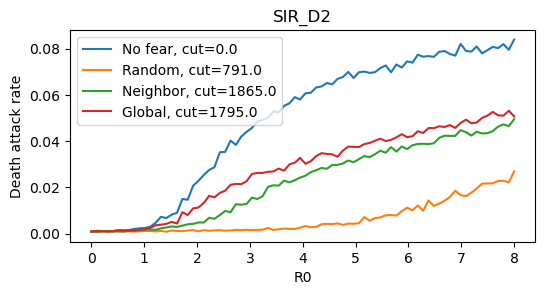

In [57]:
plot_attack_rate_vs_R0('SIR_D2', 'dead', R0_BAG_2, attack_rate_list_BAG_2, attack_rate_death_list_BAG_2, cut_avg_list_BAG_2)

## 3) Incidence depending on time

In [240]:
def temporal_avg(array, window=10):
    nuevo = np.zeros(len(d_no))
    for i in range(window,len(d_no)-window):
        nuevo[i] = np.mean(array[i-window:i+window])
    return(nuevo)

In [241]:
beta_ =  beta_pred/20
mu_ = mu_pred/20
fd_min_ = mu_/20

num_avg_= 500

stop_=200


### SIRD 1

#### -ERG

In [ ]:

i_no, d_no, cut_no = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D1',fear_type='no_fear',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
print(1)
#i_rand, d_rand, cut_rand = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D1',fear_type='random_unif',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_neighbour, d_neighbour, cut_neighbour = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D1',fear_type='neighbor',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
print(2)
i_global, d_global, cut_global = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D1',fear_type='global',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)


In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no/np.sum(i_no))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand/np.sum(i_rand))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour/np.sum(i_neighbour))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global/np.sum(i_global))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
#plt.yscale('log')

plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no/np.sum(d_no))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand/np.sum(d_rand))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour/np.sum(d_neighbour))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global/np.sum(d_global))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
#plt.yscale('log')
plt.show()

#### -BAG

In [ ]:

i_no_bag, d_no_bag, cut_no_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D1',fear_type='no_fear',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
#i_rand_bag, d_rand_bag, cut_rand_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D1',fear_type='random_unif',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_neighbour_bag, d_neighbour_bag, cut_neighbour_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D1',fear_type='neighbor',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_global_bag, d_global_bag, cut_global_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D1',fear_type='global',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)


In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_bag/np.sum(i_no_bag))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_bag/np.sum(i_rand_bag))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_bag/np.sum(i_neighbour_bag))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_bag/np.sum(i_global_bag))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected normalized (BAG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_bag)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_bag)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_bag)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_bag)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected (BAG)')
plt.xlabel('time')
plt.ylabel('incidence')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_bag/np.sum(d_no_bag))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_bag/np.sum(d_rand_bag))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_bag/np.sum(d_neighbour_bag))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_bag/np.sum(d_global_bag))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead normalized (BAG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_bag)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_bag)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_bag)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_bag)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead (BAG)')
plt.xlabel('time')
plt.ylabel('incidence')
#plt.yscale('log')
plt.show()

#### SIRD 2

#### -ERG

In [ ]:

i_no_2, d_no_2, cut_no_2 = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D2',fear_type='no_fear',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
#i_rand_2, d_rand_2, cut_rand_2 = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D2',fear_type='random_unif',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_neighbour_2, d_neighbour_2, cut_neighbour_2 = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D2',fear_type='neighbor',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_global_2, d_global_2, cut_global_2 = net_1000_ERG.plot_incidence_SIR_D(model='SIR_D2',fear_type='global',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)


In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_2/np.sum(i_no_2))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_2/np.sum(i_rand_2))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_2/np.sum(i_neighbour_2))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_2/np.sum(i_global_2))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_2)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_2)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_2)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_2)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_2/np.sum(d_no_2))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_2/np.sum(d_rand_2))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_2/np.sum(d_neighbour_2))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_2/np.sum(d_global_2))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_2)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_2)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_2)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_2)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
plt.show()

#### -BAG

In [ ]:

i_no_2_bag, d_no_2_bag, cut_no_2_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D2',fear_type='no_fear',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
#i_rand_2_bag, d_rand_2_bag, cut_rand_2_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D2',fear_type='random_unif',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_neighbour_2_bag, d_neighbour_2_bag, cut_neighbour_2 = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D2',fear_type='neighbor',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)
i_global_2_bag, d_global_2_bag, cut_global_2_bag = net_1000_BAG.plot_incidence_SIR_D(model='SIR_D2',fear_type='global',beta=beta_ , mu=mu_, fd_min=fd_min_, early_stop=True,stop=stop_, num_avg=num_avg_)


In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_2_bag/np.sum(i_no_2_bag))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_2_bag/np.sum(i_rand_2_bag))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_2_bag/np.sum(i_neighbour_2_bag))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_2_bag/np.sum(i_global_2_bag))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 50
cap_min = 5
plt.plot(np.arange(cap_min,cap_max,1),(i_no_2_bag)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),(i_rand_2_bag)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_neighbour_2_bag)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),(i_global_2_bag)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Infected (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_2_bag/np.sum(d_no_2_bag))[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_2_bag/np.sum(d_rand_2_bag))[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_2_bag/np.sum(d_neighbour_2_bag))[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_2_bag/np.sum(d_global_2_bag))[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead normalized (ERG)')
plt.xlabel('time')
plt.ylabel('incidence/attack rate')
#plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(6,2.75))
cap_max = 200
cap_min = 10
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_no_2_bag)[cap_min:cap_max],label=f'No fear, cut={np.round(cut_no)}')
#plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_rand_2_bag)[cap_min:cap_max],label=f'Random, cut={np.round(cut_rand)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_neighbour_2_bag)[cap_min:cap_max],label=f'Neighbour, cut={np.round(cut_neighbour)}')
plt.plot(np.arange(cap_min,cap_max,1),temporal_avg(d_global_2_bag)[cap_min:cap_max],label=f'Global, cut={np.round(cut_global)}')
plt.legend()
plt.title('Dead (ERG)')
plt.xlabel('time')
plt.ylabel('incidence')
plt.show()